## ResNet

ResNet[1] 即深度残差网络（Deep Residual Network），它提出了层间残差跳连，引入前方信息，减少梯度消失，使神经网络层数增加成为可能，从而具有非常强大的表征能力。

前面的介绍的四个网络，LeNet 有 5 层、AlexNet 有 8 层、VGGNet 有 16 和 19 层、InceptionNet v1（GoogLeNet）有 22 层，那么网络的精度会随着网络的层数的增加而增加吗？

在之前的实践过程中发现，如果只是简单地堆叠网络层数，很容易导致梯度消失（爆炸）问题，虽然可以使用各种标准化操作来缓解这一现象，但是随着深度更深的网络也开始收敛，网络退化的问题也随之而来：随着网络深度的增加，准确率先是达到瓶颈，然后便开始迅速下降。而且这种退化并不是由过拟合引起的。对于一个深度比较合适的网络来说，继续增加层数反而会导致训练错误率的提升。在论文 [1] 中，作者在 CIFAR-10 数据集上做了实验，实验结果显示 56 层卷积神经网络的错误率要高于 20 层卷积神经网络的错误率:

![](https://img-blog.csdn.net/20180616153149978?watermark/2/text/aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3UwMTM4NDExOTY=/font/5a6L5L2T/fontsize/400/fill/I0JBQkFCMA==/dissolve/70)

因此认为单纯堆叠神经网络层数会使神经网络模型退化，以至于后面的特征丢失了前边特征的原本摸样。

+ [1] He K , Zhang X , Ren S , et al. Deep Residual Learning for Image Recognition[C]// IEEE Conference on Computer Vision & Pattern Recognition. IEEE Computer Society, 2016.

In [1]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

### ResNet 块

![](https://img-blog.csdnimg.cn/201812171934125.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80MzYyNDUzOA==,size_16,color_FFFFFF,t_70)

这就是是 ResNet 的核心,残差结构，也叫残差块。引入残差结构最主要的目的就是解决网络层数不断加深时导致的梯度消失问题。在该结构中，ResNet 不再让下一层直接拟合我们想要得到的底层映射，而是令其对一种残差映射进行拟合，让输出结果包含了堆叠卷积的非线性输出 $F(x)$ 以及跳过两层堆叠卷积直接映射过来的恒等映射 $x$，让两者对应元素相加，即让原有映射变为 $F(x) + x$，对这种新的残差映射进行优化时，要比优化原有的非相关映射更为容易。这一操作有效缓解了神经网络模型堆叠导致的退化，使得神经网路可以向着更深层级发展。

ResNet 块中有两种情况，一种情况如下图中的实线表示，这种情况两层堆叠卷积没有改变特征图的维度，即特征图的个数、高、宽和深度都相同，可以直接将 $F(x)$ 与 $x$ 相加；另一种情况如下图的虚线表示，两层堆叠卷积改变了特征图的维度，需要借助 $1\times1$ 的卷积来调整 $x$ 的维度，使 $W(x)$ 与 $F(x)$ 的维度一致（$W(x)$ 是卷积操作）。

![](http://innofang.gitee.io/pic/tensorflow2-from-zero/ResNetBlock.jpg)

根据上面描述的 ResNet 中的残差结构，将 ResNet 块分成两种形式：
 + 堆叠卷积前后维度相同（上图中的实线）
 + 堆叠卷积前后维度不同（上图中的虚线）
 
下面将这两种形式封装到一个 ResNet 块中，用一个变量 `residual_path` 来控制两种状态，为 `True` 则表示维度不同，再使用 $1\times1$ 卷积核进行降维；又因为需要用到输入值进行额外的计算（加 $x$ 或 $W(x)$），所以输入值还需要另外的保存起来。ResNet 块内使用两次卷积：
 + 第一层卷积核大小为 $3\times3$，使用全 0 填充，步长和个数由外部控制，使用批标准化和 ReLu 激活函数
 + 第二层卷积核大小为 $3\times3$，使用全 0 填充，步长为1，个数由外部控制，使用批标准化，不使用激活函数

在最后求得 $F(x)+x$ 或者 $F(x)+W(x)$ 后，还需要过一遍 ReLu 激活函数

In [2]:
class ResidualBlock(Model):
    def __init__(self, filters, strides=1, residual_path=False):
        super(ResidualBlock, self).__init__()
        self.residual_path = residual_path
        
        self.c1 = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=strides, use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')
        
        self.c2 = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=1, use_bias=False)
        self.b2 = BatchNormalization()
        
        # residual_path 为 True 时，卷积前后维度不同，对输入用 1x1 的卷积核进行下采样，保证 x 能和 F(x) 维度相同，顺利相加
        if residual_path:
            self.down_c1 = Conv2D(filters, kernel_size=(1, 1), padding='same', strides=strides, use_bias=False)
            self.down_b1 = BatchNormalization()
        
        self.a2 = Activation('relu')
        
    def call(self, x):
         # 保存原始输入 x
        residual = x
        
        # 计算两层卷积
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        
        x = self.c2(x)
        x = self.b2(x)
        
        # 若维度不同，对原始输入 x 进一步计算得到 W(x)
        if self.residual_path:
            residual = self.down_c1(residual)
            residual = self.down_b1(residual)
        
        # 最后的计算结果送入 ReLu 激活函数得到最终输出
        y = self.a2(x + residual)
        return y

### ResNet 网络结构

使用 ResNet 来训练 Fashion MNIST 数据集，网络一共 18 层：
 + 第一层：卷积层
  + 64 个 $7\times7$ 卷积核，步长为 2，使用全 0 填充（same）
  + 使用批标准化
  + 使用 ReLu 激活函数
  + 使用 $3\times3$ 的池化核，采用最大值池化，步长为 2，全 0 填充（same）
 + 中间使用 8 个 ResNet 块，共 16 层，如下图中由蓝色框住的部分所示：
 + 对以上传过来的特征图数据使用一次全局平均池化 （Global Average Pooling）
 + 第十层：全连接层
  + 10 个神经元
  + 使用 softmax 激活函数

![](http://InnoFang.gitee.io/pic/tensorflow2-from-zero/ResNet18.jpg)

对于中间连续的残差块，将其两两分为一组大块。可以发现除了第一个大块之外，后面的三个块都具有类似的结构：块内第一个残差块的卷积前后维度不同，第二个残差块的卷积前后维度相同。因此为了简化代码，可以使用函数进行简单的封装。定义一个 `resnet_block` 函数，参数列表如下：
 + channels：通道数
 + residuals：残差块个数
 + first_block：是否是第一个大块，第一个大块内的卷积前后维度一致，用来与后面三个大块进行区分

In [3]:
def resnet_block(channels, residuals, first_block=False):
        blk = Sequential()
        for i in range(residuals):
            if i == 0 and not first_block:
                blk.add(ResidualBlock(channels, strides=2, residual_path=True))
            else:
                blk.add(ResidualBlock(channels))
        return blk

接下来就可以堆叠网络结构了

In [4]:
resnet18 = [
    Conv2D(64, kernel_size=(7, 7), strides=2, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=(3, 3), strides=2, padding='same'),
    resnet_block(64, 2, first_block=False),
    resnet_block(128, 2),
    resnet_block(256, 2),
    resnet_block(512, 2),
    GlobalAveragePooling2D(),
    Dense(10, activation='softmax')
]

In [5]:
# 导入数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() 
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [6]:
# ResNet18
model = Sequential(resnet18)

In [7]:
# 配置模型参数
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [8]:
# 设置断点续训
checkpoint_save_path = './checkpoint/VGGNet16.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model.load_weights(checkpoint_save_path)

In [9]:
# 设置保存最优模型参数回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_best_only=True,
                                                save_weights_only=True)

In [10]:
# 训练模型
history = model.fit(x_train, y_train,
                    batch_size=256,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    validation_freq=1,
                    callbacks=[cp_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1773s 30ms/sample - loss: 0.5541 - sparse_categorical_accuracy: 0.8137 - val_loss: 0.8002 - val_sparse_categorical_accuracy: 0.6936
Epoch 2/5
60000/60000 [==============================] - 1721s 29ms/sample - loss: 0.3287 - sparse_categorical_accuracy: 0.8791 - val_loss: 0.3546 - val_sparse_categorical_accuracy: 0.8668
Epoch 3/5
60000/60000 [==============================] - 1770s 29ms/sample - loss: 0.2786 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.3605 - val_sparse_categorical_accuracy: 0.8661
Epoch 4/5
60000/60000 [==============================] - 1694s 28ms/sample - loss: 0.2579 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.3241 - val_sparse_categorical_accuracy: 0.8717
Epoch 5/5
60000/60000 [==============================] - 1756s 29ms/sample - loss: 0.2344 - sparse_categorical_accuracy: 0.9136 - val_loss: 0.3318 - val_sparse_categorical_accuracy: 0.8831


In [11]:
# 打印网络结构
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3200      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  152832    
_________________________________________________________________
sequential_1 (Sequential)    multiple                  526848    
_________________________________________________________________
sequential_2 (Sequential)    multiple                 

In [12]:
np.set_printoptions(threshold=np.inf)
# 保存参数信息
with open('./data/weights.txt', 'w') as file:
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')

In [13]:
# 获取 acc 和 loss 曲线数据
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

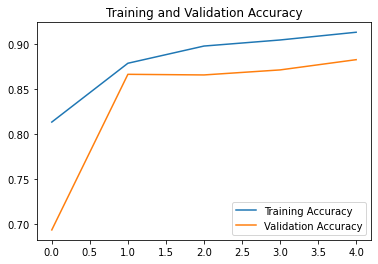

In [14]:
# 可视化 acc 曲线
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

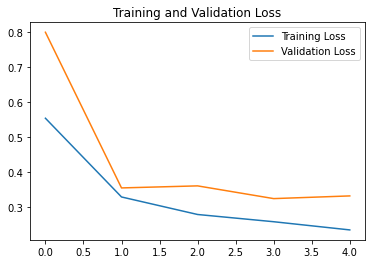

In [15]:
# 可视化 loss 曲线
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()